In [1]:
#Skalowanie daje slabe wyniki, bez skalowania jest duzo lepiej
#batch normalization polepszylo znaczaco wyniki
#

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [195]:
tf.get_logger().setLevel('INFO')
from tensorflow.keras.layers import Input, GRU, LSTM, RepeatVector, Dense, Flatten, Reshape, Conv1D, Conv1DTranspose, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MSE
# import numpy as np
import matplotlib.pyplot as plt
# from keras import backend as K
from mpl_toolkits.mplot3d import Axes3D
# import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Generate data

In [196]:
def generate_line(a, b, n=32, noise=0):
    x = np.arange(n)
    return a * x + b + np.random.normal(0, noise, n)

def generate_lines(a, bs, n_train, c, lines, labels):
    for b in bs:
        generated_lines = np.array([generate_line(a, b, noise=0.005) for _ in range(int(n_train/16))])
        generated_labels = np.array([c for _ in range(int(n_train/16))])
        if lines.size == 0:
            lines = generated_lines
            labels = generated_labels
        else:
            lines = np.concatenate((lines, generated_lines))
            labels = np.concatenate((labels, generated_labels))
    return lines, labels
    
def generate_lines_set(n_train):    
    lines = np.array([])
    labels = np.array([])

    lines, labels = generate_lines(0, [0, .4, .8, 1.2, 1.6, 2], n_train, 'g', lines, labels)
    lines, labels = generate_lines(0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'r', lines, labels)
    lines, labels = generate_lines(-0.01, [.2, .6, 1, 1.4, 1.8], n_train, 'b', lines, labels)

    return np.array(lines), np.array(labels)
    

In [197]:
n_lines = 64000
n_types = 16
x_train, y_train = generate_lines_set(64000)

# Scale data

In [198]:
x_train = (x_train - np.amin(x_train)) / (np.amax(x_train) - np.amin(x_train))

In [199]:
# scaler = StandardScaler()
# scaler.fit(x_train)
# x_train = scaler.transform(x_train)

# Plot data

4000


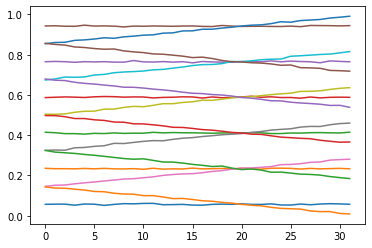

In [200]:
plot_lines = np.concatenate((x_train[1000:1010], x_train[11000:11010], x_train[21000:21010], x_train[31000:31010],x_train[41000:41010],x_train[51000:51010])) 
index = 10
interval = int(n_lines / n_types)
print(interval)
while index < n_lines:
    plt.plot(x_train[index])
    index += interval

# Create model

In [244]:
original_dim = 32
intermediate_dim = 16
batch_size = 128
latent_dim = 8
epochs = 10


def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim), stddev=0.1)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [245]:
#ENCODER
inputs = Input(shape=(original_dim, 1), name='encoder_input')
x = GRU(intermediate_dim, name='encoder_LSTM')(inputs)
x = BatchNormalization()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()

#DECODER
latent_inputs = Input(shape=(latent_dim, ), name='z_sampling')

In [246]:
# x = RepeatVector(intermediate_dim)(latent_inputs)
# x = LSTM(1, return_sequences=True, name='decoder_conv1D')(x)
# x = BatchNormalization()(x)
# outputs = LSTM(original_dim, name='decoder_output')(x)

In [247]:
# x = RepeatVector(original_dim)(latent_inputs)
# x = LSTM(intermediate_dim, return_sequences=True, name='decoder_conv1D')(x)
# x = BatchNormalization()(x)
# outputs = LSTM(1, return_sequences=True, name='decoder_output')(x)

In [248]:
x = Reshape((latent_dim, 1))(latent_inputs)
x = GRU(intermediate_dim, return_sequences=True, name='decoder_conv1D')(x)
x = BatchNormalization()(x)
outputs = GRU(original_dim, name='decoder_output')(x)

In [249]:
decoder = Model(latent_inputs, outputs, name='decoder')
# decoder.summary()

#VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [250]:
models = (encoder, decoder)
reconstruction_loss = MSE(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + (1 * kl_loss))
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.summary()

# Learn data

In [251]:
hist = vae.fit(x_train, epochs=1, batch_size=batch_size)

500/500 [==============================] - 4s 8ms/step - loss: 0.9899


In [252]:
hist.history

{'loss': [0.9899328947067261]}

Loss: 0.99, DB: 6.13, CH: 1754.56


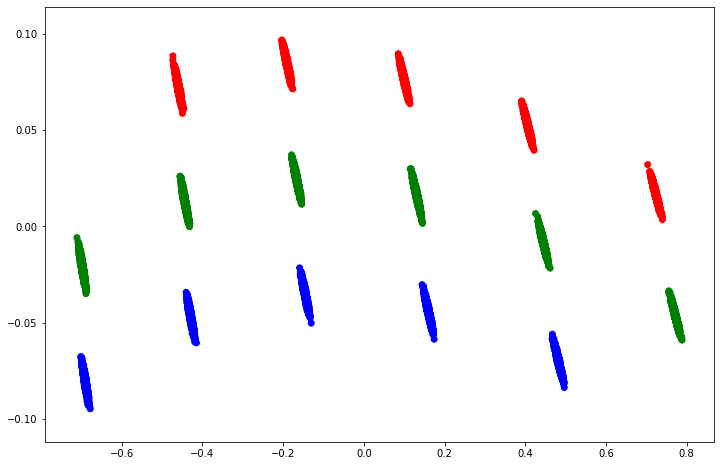

In [253]:
z_mean, _, _ = encoder.predict(x_train, batch_size=batch_size)
db8_score = round(davies_bouldin_score(z_mean, y_train), 2)
ch8_score = round(calinski_harabasz_score(z_mean, y_train), 2)
loss = round(hist.history['loss'][-1], 2)
z_mean = PCA(n_components=2).fit_transform(z_mean)
print(f"Loss: {loss}, DB: {db8_score}, CH: {ch8_score}")

plt.figure(figsize=(12,8))
plt.scatter(z_mean[:, 0], z_mean[:, 1],  c=y_train)

Loss: 0.15, DB: 5.76, CH: 2468.08


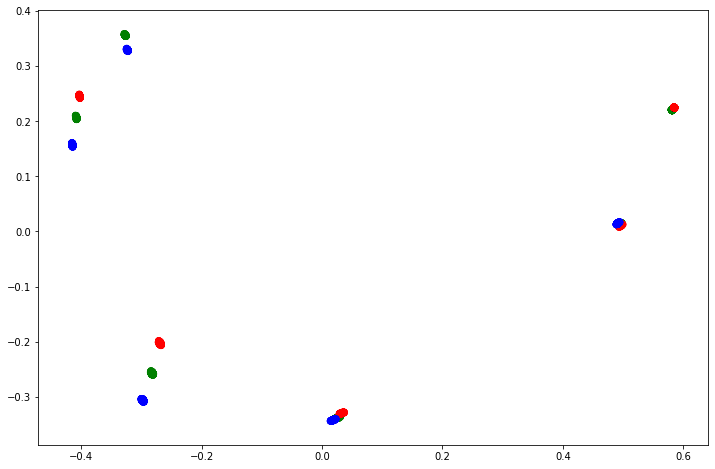

In [71]:
z_mean, _, _ = encoder.predict(x_train, batch_size=batch_size)
db8_score = round(davies_bouldin_score(z_mean, y_train), 2)
ch8_score = round(calinski_harabasz_score(z_mean, y_train), 2)
loss = round(hist.history['loss'][-1], 2)
z_mean = PCA(n_components=2).fit_transform(z_mean)
print(f"Loss: {loss}, DB: {db8_score}, CH: {ch8_score}")

plt.figure(figsize=(12,8))
plt.scatter(z_mean[:, 0], z_mean[:, 1],  c=y_train)

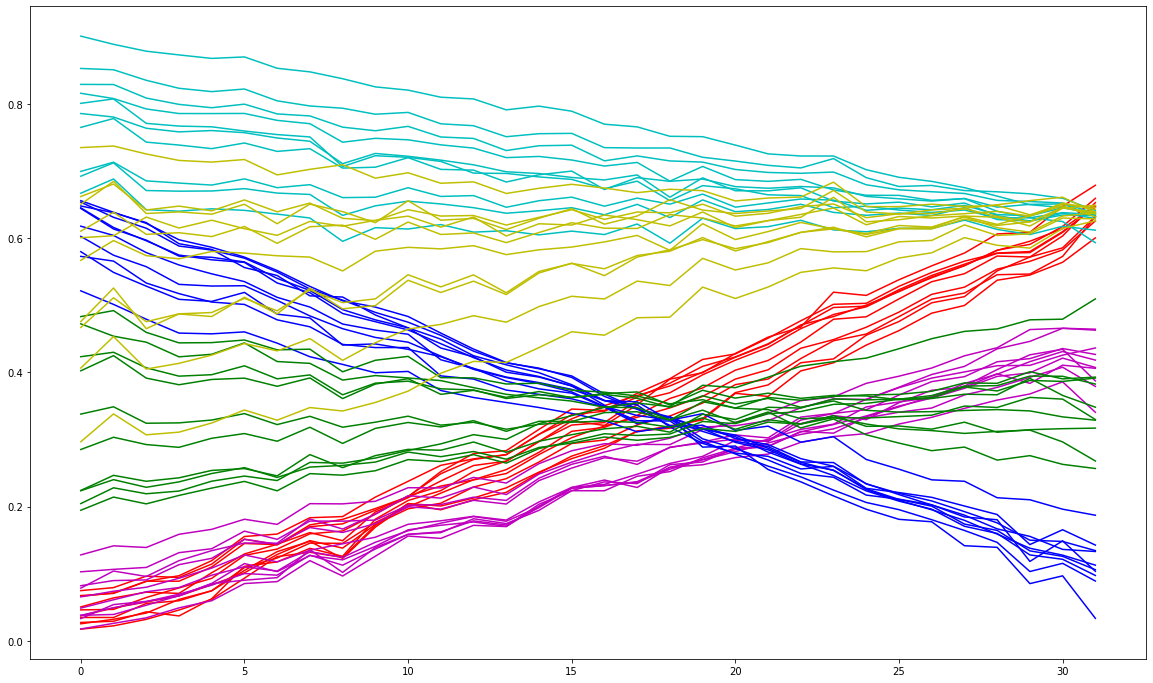

In [16]:
res = vae.predict(x_train, batch_size=128)
res_lines = np.concatenate((res[1000:1010], 
                            res[11000:11010], 
                            res[21000:21010], 
                            res[31000:31010],
                            res[41000:41010],
                            res[51000:51010])) 
res_colors = np.concatenate((y_train[1000:1010], 
                             y_train[11000:11010], 
                             y_train[21000:21010], 
                             y_train[31000:31010],
                             y_train[41000:41010],
                             y_train[51000:51010]))

plt.figure(figsize=(20,12))
for (l, c) in zip(res_lines, res_colors):
    plt.plot(l, c=c)

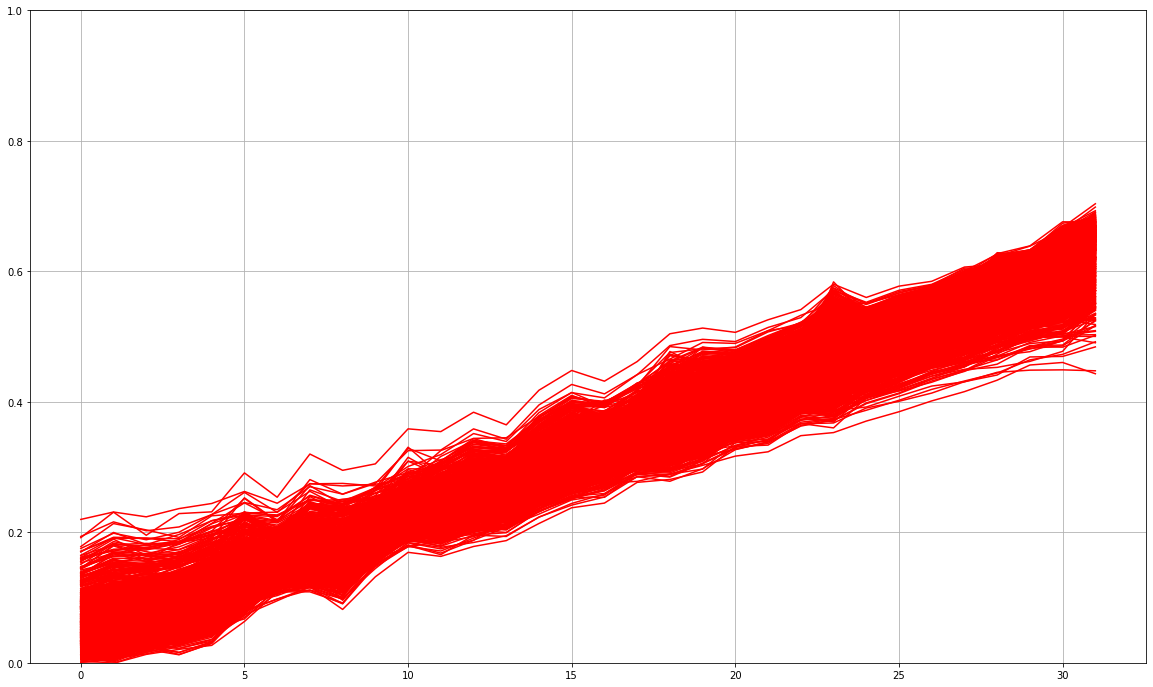

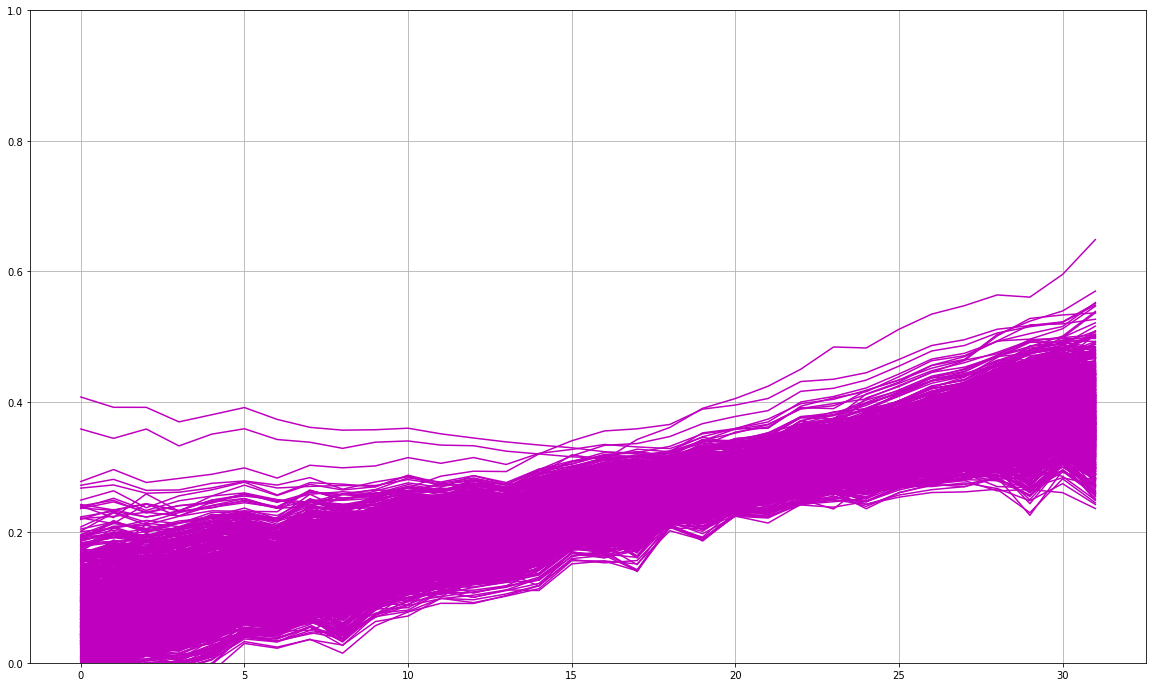

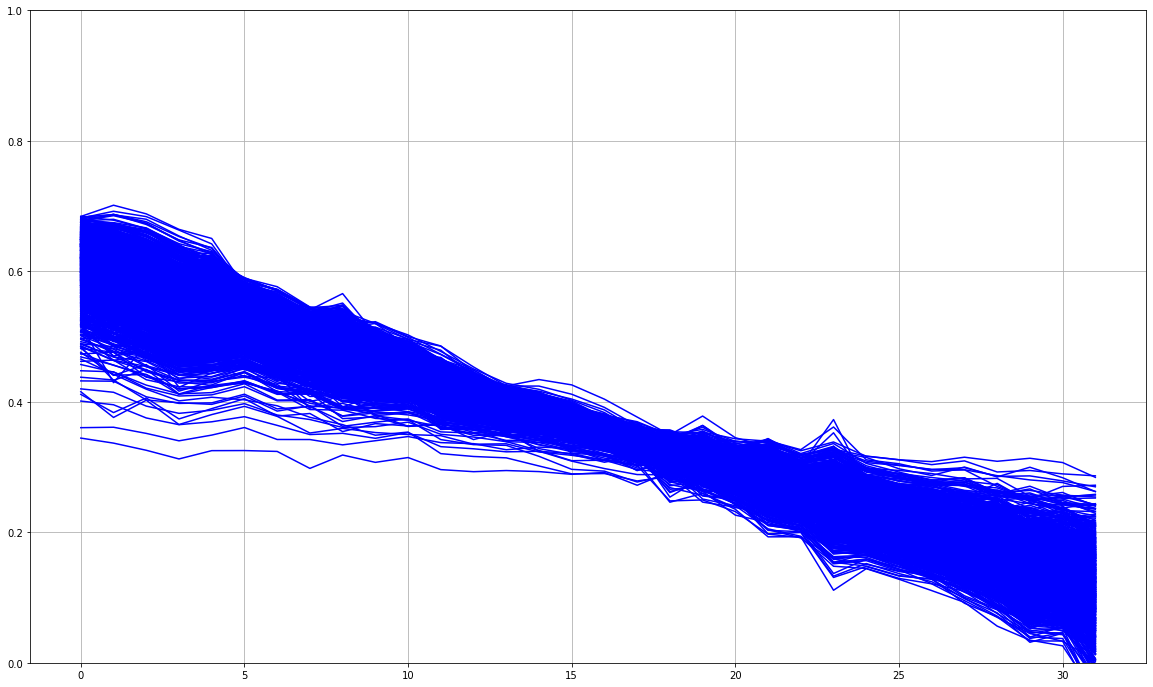

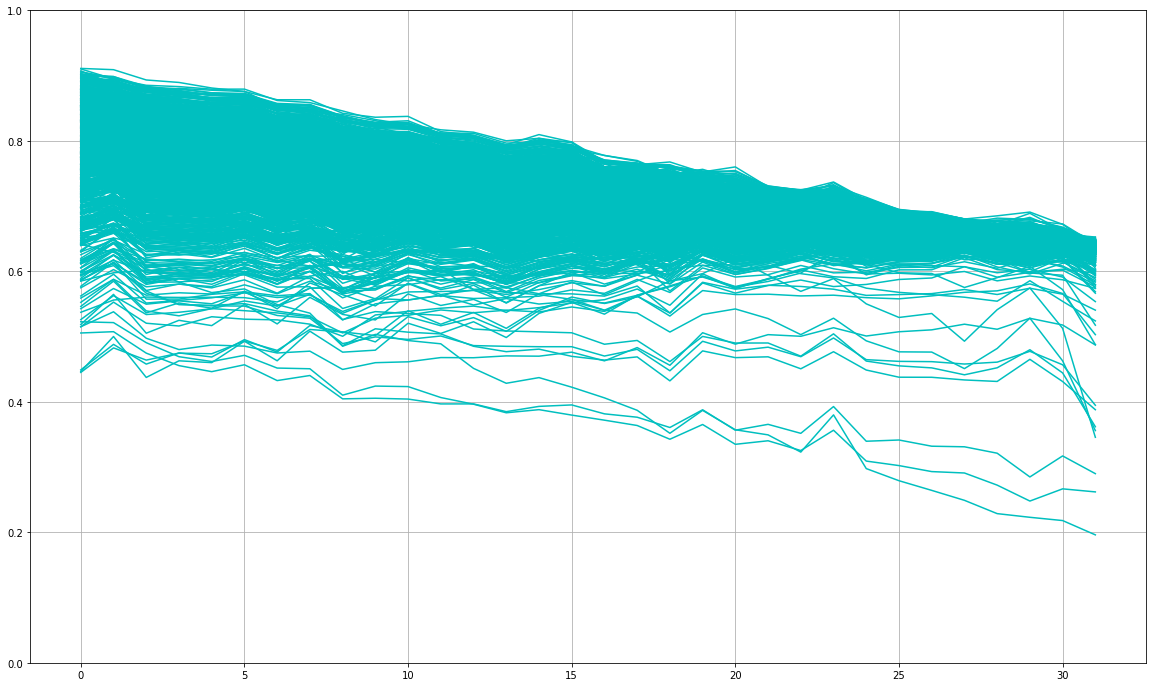

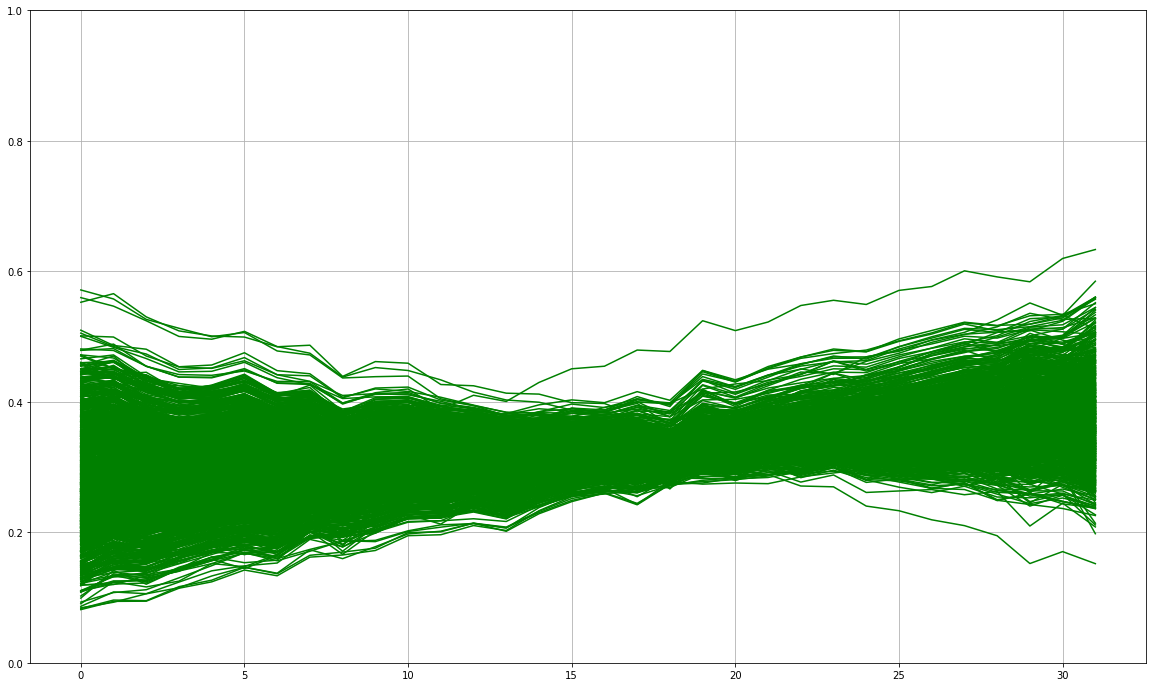

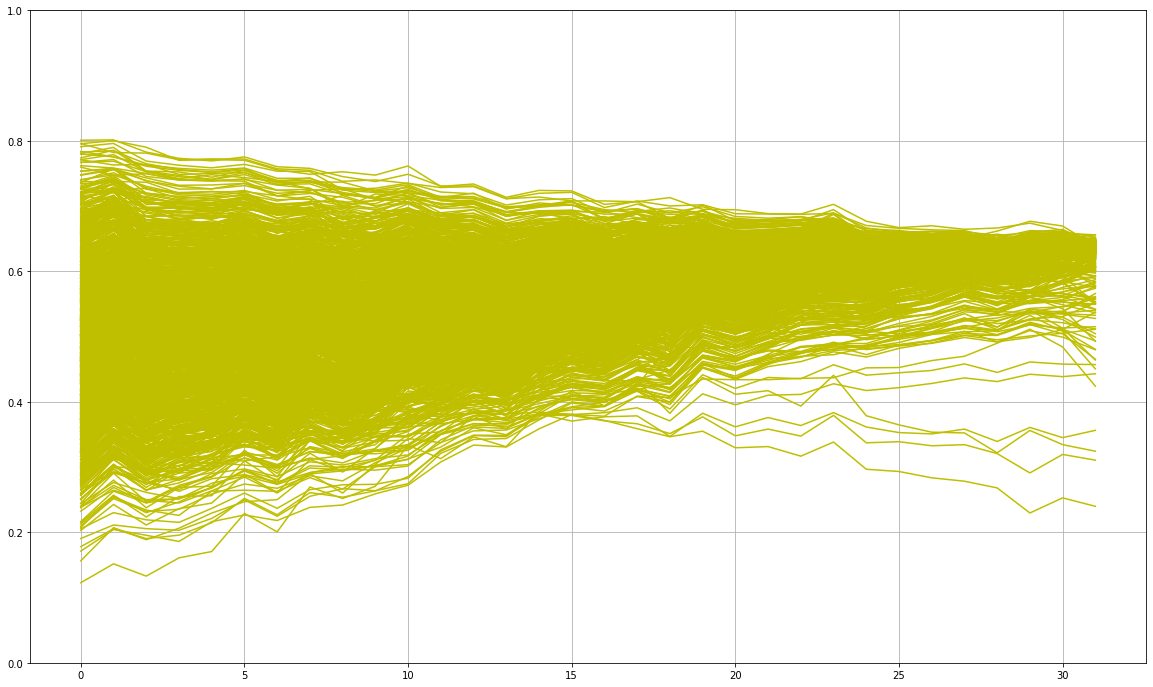

In [17]:
low = 0
high = 1000
d = 10000

for i in range(6):
    res_lines = res[low:high]
    res_colors = y_train[low:high]
    plt.figure(figsize=(20,12))
    plt.ylim((0,1))
    plt.grid()
    for (l, c) in zip(res_lines, res_colors):
        plt.plot(l, c=c)
    low += d
    high += d